![image info](./images/Human-With-Sensors.png)

## Problem definition and data description

### Problem Definition
Our company (Spotify) would like to dynamically target advertising to non-premium members based on their physical activity while using Spotify services. For example, while a listener is enjoying a podcast and folding their laundry, they would receive an ad for laundry detergent. 

In addition Spotify also wishes to cater to our premium members by enhancing music recommendation/auto-play options based on a members physical activity. For example, while a user is exercising play up-tempo music, and while a user is eating pasta play Italian classics.

### Data Description

Accelerometer (measures proper acceleration) and Gyroscope (measures orientation and angular velocity) data was collected from 51 volunteer subjects. Each subject was asked to perform 18 tasks for 3 minutes each. The 18 tasks were a mix of physical activities that could be distinctly identified, such as walking, eating, laundry, etc. We (Spotify) tried to collect data for activities that our members might be doing while using our services. The tasks are listed below.

![image info](./images/Activity-Code-Table.png)

Each subject had a smartwatch placed on his/her dominant hand and a smartphone in their pocket. The smartphone and smartwatch both had an accelerometer and gyrocope, yielding four total sensors (Phone - Gyroscope, Phone - Accelerometer, Watch - Gyroscope, Watch - Accelerometer).

![image info](./images/Human-With-Sensors.png)

To accomodate the four sensors, the data is split up into 4 subdirectories, one for each device and sensor. 

![image info](./images/Sensor-Subdirectories.png)

Each directory contains the sensor results for the 51 subject's performance of the 18 activities. The results for each subject are stored in a comma delimited text file. Since there are 51 subjects and 4 different sensors, there are a total of 204 text files. Each text file has the same six attributes: Subject-id, Activity Code, Timestamp, x, y, z

![image info](./images/Raw-Data-Description.png)

## Data preparation process

Our data is pretty clean, we don't need to do a lot of preproccessing/data engineering. We really just need to do the ML side, which, lends itself more to the majority of work we need to do with this project. We stuck with dask so we could use the natural integration it has with python, as well as its similiar syntax to Pandas.

To clean, prepare and train our data, we decided to go with dask. Our reasoning was that, while our data was large (approx. 15 million records, ~1 gb), it was not large enough to warrant the use of Spark. The image below summarizes our thoughts on the choice between dask vs spark.

![image info](./images/Pandas-Dask-Spark-Compare.png)

### Importing the data

To shortstep the inconvenience of downloading and importing over 200 text files, we decided to host all the data on github for easy access (https://github.com/gojandrooo/DSE-230/tree/main/data). To quickly pull the github data into a pandas dataframe, we defined a function collate_df that will pull in all data matching the parameters given.

Begin by importing all the necessary libraries

Running within *Docker* container you will need to install libraries not already included in the image.
- comment/uncomment the `%pip install` cell (below)
- run the cell, wait for the packages to install, and then restart notebook. 
- once installs are complete, comment out the cell and run all

In [4]:
%pip install plotly
%pip install dask_distance

Note: you may need to restart the kernel to use updated packages.
  Created wheel for dask-distance: filename=dask_distance-0.2.0-py2.py3-none-any.whl size=9069 sha256=2b9bd68bb8c5a690971cfa4d19608afb7eacd8c392eae1a9e19a073d3040b045
  Stored in directory: /home/.cache/pip/wheels/7f/1a/8f/7f5269f3670f46d69b900921a8f06f7592daf09572ea27865b
Successfully built dask-distance
Note: you may need to restart the kernel to use updated packages.


In [5]:
#set a random state seed for replication
seed=23

In [6]:
# libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import itertools as it

import dask
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client
import joblib

# model processing libraries
import dask_distance
from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import StandardScaler
#from sklearn.model_selection import GridSearchCV
import dask_ml.model_selection as dcv

# models
# will need to update these with the models we use
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans

import ssl
# needed to request files when run from within docker container
ssl._create_default_https_context = ssl._create_unverified_context

In [7]:
# Start and connect to a local dask.distributed client
client = Client()
client.connection_args

{'ssl_context': None, 'require_encryption': False, 'extra_conn_args': {}}

Get data from github and prep files for analysis

In [8]:
# key for understanding which activity is being measured in a record
activity_key_url = r"https://raw.githubusercontent.com/gojandrooo/DSE-230/main/data/activity_key.txt"

#read the activity table from gtihub
activity_key = pd.read_csv(activity_key_url, header=None)

#split the data into a proper table
activity_key = activity_key[0].str.replace(" ", "").str.split("=", expand=True)
activity_key.columns = ['activity', 'code']
#activity_key

In [9]:
# NOTE
# this still only grabs three spreadsheets, update for production

def collate_dask_df(device, data_type):

    '''
    returns a single dask dataframe from multiple text files hosted on github
    
    device: ["phone", "watch"]
    
    data_type: ["accel", "gyro"]
    ----------------------------
    '''
    
    base_url = r"https://raw.githubusercontent.com/gojandrooo/DSE-230/main/data"

    # TOGGLE FOR DEVICE
    device = device

    # TOGGLE FOR MEASUREMENT TYPE
    data_type = data_type
    
    # create list of all file names
    file_names = [f"/data_{user_id}_{data_type}_{device}.txt" for user_id in range(1600, 1651)]

    # create urls of all files
    loop_urls = [base_url + "/" + device + "/" + data_type + file_name for file_name in file_names]
    
    # concatenate data into one object
    '''still uses `pandas.read_csv` instead of `dask.read_csv` due to certificate issue'''
    dask_df = dd.multi.concat([pd.read_csv(url, header=None) for url in loop_urls[:3]]) # for dev this is only the first three files
    #dask_df = dd.multi.concat([pd.read_csv(url, header=None) for url in loop_urls]) # PRODUCTION, all of the files
    
    dask_df.columns = ['subject_id', 'code', 'timestamp', 'x', 'y', 'z']
    dask_df['z'] = dask_df['z'].str.replace(";", "").astype('float64')
    dask_df = dask_df.reset_index(drop = True)
    
    return dask_df # dask df output

In [10]:
collate_dask_df?

Signature: collate_dask_df(device, data_type)
Docstring:
returns a single dask dataframe from multiple text files hosted on github

device: ["phone", "watch"]

data_type: ["accel", "gyro"]
----------------------------
File:      /tmp/ipykernel_424/1638094770.py
Type:      function


In [11]:
%%time
phone_accel_dd = collate_dask_df("phone", "accel")

CPU times: user 473 ms, sys: 195 ms, total: 668 ms
Wall time: 5.65 s


In [12]:
# create the dask dataframes for each sensor
phone_accel = collate_dask_df("phone", "accel")
phone_gyro = collate_dask_df("phone", "gyro")
watch_accel = collate_dask_df("watch", "accel")
watch_gyro = collate_dask_df("watch", "gyro")
phone_accel.head(3)

,subject_id,code,timestamp,x,y,z
0,1600,A,252207666810782,-0.364761,8.793503,1.055084
1,1600,A,252207717164786,-0.879730,9.768784,1.016998
2,1600,A,252207767518790,2.001495,11.109070,2.619156


### EDA
Below we compare the accelerometer sensors results and the gyroscope results independently. This is because the sensors have different units. The accelerometer sensor has units in m/s^2 while the gyroscope has units in radians/s.

In [13]:
feat_cols = ['x', 'y', 'z']
phone_accel_stats = phone_accel[feat_cols].describe().compute()
watch_accel_stats = watch_accel[feat_cols].describe().compute()
accel_stats = phone_accel_stats.merge(watch_accel_stats, left_index=True, right_index=True, suffixes=('_phone_accel', '_watch_accel'))
accel_stats.reindex(sorted(accel_stats.columns), axis=1)

,x_phone_accel,x_watch_accel,y_phone_accel,y_watch_accel,z_phone_accel,z_watch_accel
count,230658.000000,195287.000000,230658.000000,195287.000000,230658.000000,195287.000000
mean,-0.703180,0.850824,2.211592,-4.430207,4.625158,3.001613
std,3.209020,7.038872,6.754970,4.716424,4.424380,4.942298
min,-19.613300,-19.717150,-19.613300,-19.779099,-19.753006,-19.820848
25%,-2.299631,-1.479168,-1.756149,-6.903344,1.296925,0.387524
50%,-1.453720,0.653467,1.520917,-2.625242,5.847239,3.199177
75%,2.898041,7.620744,9.495972,-0.746093,8.954769,7.212383
max,19.612701,19.761143,19.613052,19.990686,19.612701,19.693506


In [14]:
phone_gyro_stats = phone_gyro[feat_cols].describe().compute()
watch_gyro_stats = watch_gyro[feat_cols].describe().compute()
gyro_stats = phone_gyro_stats.merge(watch_gyro_stats, left_index=True, right_index=True, suffixes=('_phone_gyro', '_watch_gyro'))
gyro_stats.reindex(sorted(gyro_stats.columns), axis=1)

,x_phone_gyro,x_watch_gyro,y_phone_gyro,y_watch_gyro,z_phone_gyro,z_watch_gyro
count,209726.000000,195214.000000,209726.000000,195214.000000,209726.000000,195214.000000
mean,-0.002489,-0.026488,-0.003224,0.004399,-0.006940,-0.003257
std,0.781196,1.534488,0.776514,1.541887,0.482266,1.383244
min,-8.240326,-27.318910,-8.726380,-34.900160,-6.119944,-22.955528
25%,-0.020798,-0.282004,-0.021305,-0.187030,-0.018242,-0.193673
50%,0.000320,0.000907,0.000351,0.001644,-0.000214,0.002615
75%,0.026535,0.365357,0.035599,0.277855,0.029949,0.279046
max,8.706141,22.754925,8.722385,15.498922,8.703211,13.778158


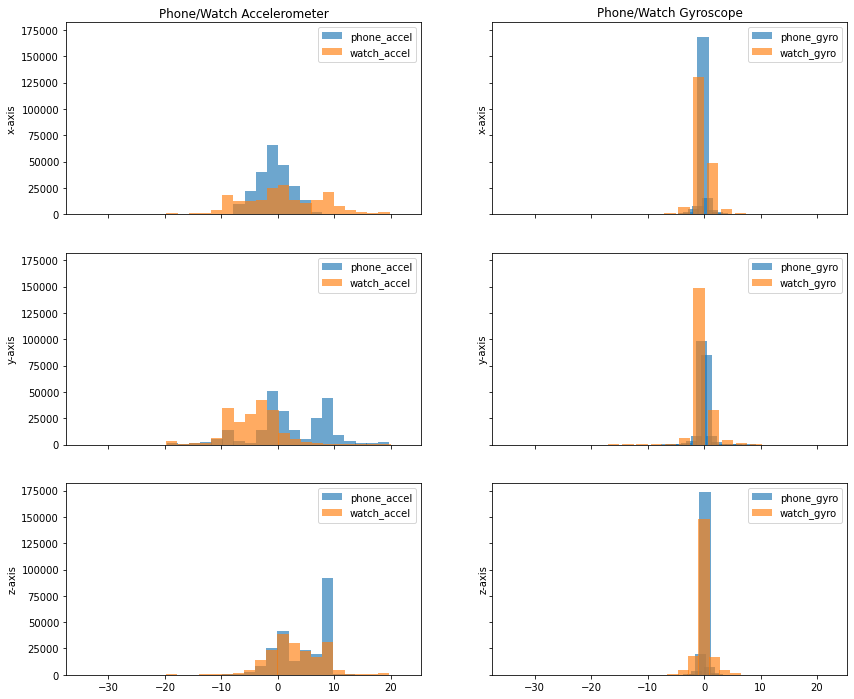

In [15]:
# FUNCTIONIZED IMPLEMENTATION

#calculate the histograms using the dask dataframes
#since dask deals with large data we cant easily graph the dataframe
#need to get all the histograms by hand and plot

sensor_dfs = [phone_accel, watch_accel, phone_gyro,  watch_gyro]
sensor_labels = ['phone_accel', 'watch_accel', 'phone_gyro',  'watch_gyro']

def hist_subplot(dask_df, axis, n_bins, data_label, ax_row, ax_col):
    '''
    helper function to plot histograms
    
    dask_df: underlying dataframe
    
    axis: ['x', 'y', 'z']
    
    n_bins: int
    
    ax_row: subplot location
    ax_col: subplot location
    '''
    
    h, bins = da.histogram(dask_df[axis], bins=n_bins, range=[dask_df[axis].min().compute(), dask_df[axis].max().compute()])
    bincenter = (bins[:-1] + bins[1:]) / 2
    axes[ax_row,ax_col].bar(bincenter, list(h.compute()), align='center', width=2, alpha=0.65, label = data_label)
    axes[ax_row,ax_col].legend(loc='best')

    
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(14,12))
    
# x-axis - firt row of subplot
axis = 'x'
i = 0
hist_subplot(sensor_dfs[i], axis, 20, sensor_labels[i], 0, 0)
i = 1
hist_subplot(sensor_dfs[i], axis, 20, sensor_labels[i], 0, 0)
i = 2
hist_subplot(sensor_dfs[i], axis, 20, sensor_labels[i], 0, 1)
i = 3
hist_subplot(sensor_dfs[i], axis, 20, sensor_labels[i], 0, 1)

# y-axis - second row of subplot
axis = 'y'
i = 0
hist_subplot(sensor_dfs[i], axis, 20, sensor_labels[i], 1, 0)
i = 1
hist_subplot(sensor_dfs[i], axis, 20, sensor_labels[i], 1, 0)
i = 2
hist_subplot(sensor_dfs[i], axis, 20, sensor_labels[i], 1, 1)
i = 3
hist_subplot(sensor_dfs[i], axis, 20, sensor_labels[i], 1, 1)

# z-axis - third row of subplot
axis = 'z'
i = 0
hist_subplot(sensor_dfs[i], axis, 20, sensor_labels[i], 2, 0)
i = 1
hist_subplot(sensor_dfs[i], axis, 20, sensor_labels[i], 2, 0)
i = 2
hist_subplot(sensor_dfs[i], axis, 20, sensor_labels[i], 2, 1)
i = 3
hist_subplot(sensor_dfs[i], axis, 20, sensor_labels[i], 2, 1)

axes[0,0].set_title('Phone/Watch Accelerometer')
axes[0,1].set_title('Phone/Watch Gyroscope')

plt.setp(axes[0, :], ylabel='x-axis')
plt.setp(axes[1, :], ylabel='y-axis')
plt.setp(axes[2, :], ylabel='z-axis')

plt.show()

In [17]:
# VISUALIZE DATA
# just a sample

# depending on your setup may need different renderer to display
# iframe should render on local implementation and docker image implementation

renderer = [
    'notebook', # local
    'notebook_connected', # local
    'kaggle', # local
    'azure', # local
    'browser', # local (opens plot in new browser tab)
    'iframe', # docker, local (saves plot in `iframe_figures` folder)
    'iframe_connected', # docker, local (saves plot in `iframe_figures` folder)
    'colab' # docker
]

# take a sample of the data
df = phone_accel.sample(frac=0.2, random_state=seed).sort_values(by='code').compute()
fig = px.scatter_3d(df, 
                    x='x', 
                    y='y', 
                    z='z',
                    color='code')
fig.show(renderer=renderer[-2]) # if plot does not render, try a different index, the last three are preferred

### Preparing the data for merging/grouping
Adding custom index so merge is more efficient

In [18]:
#set custom index for joining
#joining on an index in dask optimizes the operation
#might be even faster if we create this column during the data ingestion phase of collate_dask_df
phone_accel['index'] = phone_accel['subject_id'].astype('str') + phone_accel['code'] + phone_accel['timestamp'].astype('str')
phone_gyro['index'] = phone_gyro['subject_id'].astype('str') + phone_gyro['code'] + phone_gyro['timestamp'].astype('str')
watch_accel['index'] = watch_accel['subject_id'].astype('str') + watch_accel['code'] + watch_accel['timestamp'].astype('str')
watch_gyro['index'] = watch_gyro['subject_id'].astype('str') + watch_gyro['code'] + watch_gyro['timestamp'].astype('str')

In [19]:
phone_accel = phone_accel.set_index('index')
phone_gyro = phone_gyro.set_index('index')
watch_accel = watch_accel.set_index('index')
watch_gyro = watch_gyro.set_index('index')

In [20]:
# phone shapes
dask.compute(phone_accel.shape, phone_gyro.shape)

((230658, 6), (209726, 6))

In [21]:
# watch shapes
dask.compute(watch_accel.shape, watch_gyro.shape)

((195287, 6), (195214, 6))

In [ ]:
feat_cols = ['x', 'y', 'z']
def merge_dfs(df1, df2, suffixes):
    df1partitions = df1.npartitions
    df2partitions = df2.npartitions
    partitions = max(df1partitions, df2partitions)
    merged =  dd.merge(df1, df2[feat_cols], how='inner', left_index = True, right_index = True, 
                    suffixes=suffixes).reset_index(drop = True)
    return dd.from_pandas(merged.compute(), npartitions = partitions)

In [ ]:
# attempt to merge phone data
''' trying to join on custom 'index' column defined above. per dask best practices, this is much better than joining on multiple columns. In fact, joining on
multiple columns is the slowest method

phone_df = dd.merge(phone_accel, phone_gyro, how='inner', left_on=['subject_id', 'code', 'timestamp'], right_on=['subject_id', 'code', 'timestamp'], 
                    suffixes=('_phone_accel', '_phone_gyro')).reset_index(drop = True)
                    
phone_df = dd.merge(phone_accel, phone_gyro[feat_cols], how='inner', left_index = True, right_index = True, 
                    suffixes=('_phone_accel', '_phone_gyro'))
                    
phone_df = dask.delayed(merge_dfs)(phone_accel, phone_gyro[feat_cols], ('_phone_accel', '_phone_gyro'))
                    '''
phone_df = merge_dfs(phone_accel, phone_gyro[feat_cols], ('_phone_accel', '_phone_gyro'))
phone_df.head()

In [ ]:
# attempt to merge watch data
'''
watch_df = dd.merge(watch_accel, watch_gyro, how='inner', left_on=['subject_id', 'code', 'timestamp'], right_on=['subject_id', 'code', 'timestamp'], 
                    suffixes=('watch_accel', 'watch_gyro')).reset_index(drop = True)
                    
watch_df = dask.delayed(merge_dfs)(watch_accel, watch_gyro[feat_cols], ('_watch_accel', '_watch_gyro'))
                    '''

watch_df = merge_dfs(watch_accel, watch_gyro[feat_cols], ('_watch_accel', '_watch_gyro'))
watch_df.head()

In [ ]:
dask.compute(phone_df.shape[0], watch_df.shape[0])

In [ ]:
# result of inner join
records_remaining = sum(dask.compute(phone_df.shape[0], watch_df.shape[0]))
"{:,.0f}".format(records_remaining)

### Scaling the data

In [30]:
#maybe we won't even do this. if we do, we need to define train_test_split up here
'''
code for scaling is at the ML stage if we want to move it
'''

### Aggregating the data
Grouping averages into n second intervals

In [75]:
'''
need to build in logic to compute below figures for the same rows that compute the average
'''

'\nneed to build in logic to compute below figures for the same rows that compute the average\n'

2022-05-22 23:33:24,978 - distributed.nanny - WARNING - Restarting worker
2022-05-22 23:33:24,982 - distributed.nanny - WARNING - Restarting worker
2022-05-22 23:33:24,999 - distributed.nanny - WARNING - Restarting worker
2022-05-22 23:33:25,017 - distributed.nanny - WARNING - Restarting worker
2022-05-22 23:33:25,069 - distributed.nanny - WARNING - Restarting worker
2022-05-22 23:33:25,073 - distributed.nanny - WARNING - Restarting worker
2022-05-22 23:33:25,172 - distributed.nanny - WARNING - Restarting worker
2022-05-22 23:33:25,174 - distributed.nanny - WARNING - Restarting worker
2022-05-22 23:33:25,189 - distributed.nanny - WARNING - Restarting worker
2022-05-22 23:33:25,205 - distributed.nanny - WARNING - Restarting worker
2022-05-22 23:33:25,475 - distributed.nanny - WARNING - Restarting worker
2022-05-22 23:33:25,477 - distributed.nanny - WARNING - Restarting worker
2022-05-22 23:33:25,492 - distributed.nanny - WARNING - Restarting worker
2022-05-22 23:33:25,509 - distributed.

within each n_second agregation, map relationship between each of the x/y/x paired arrays
- COSINE
    - xy
    - xz
    - yz
- CORRELATION
    - xy
    - xz
    - yz

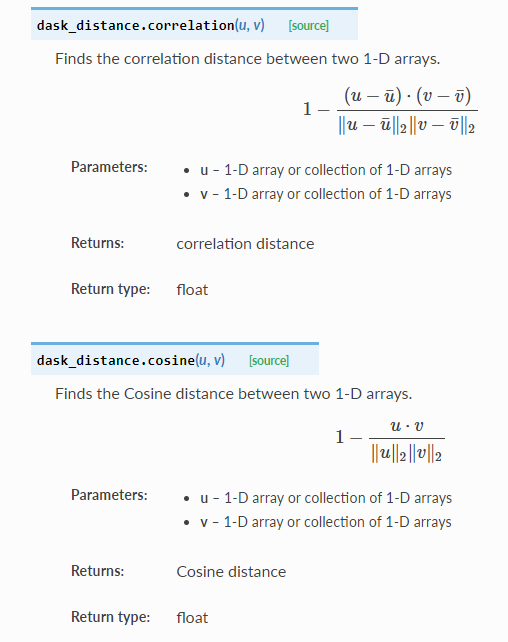

In [57]:
feat_cols

['x', 'y', 'z']

In [62]:
col_combos = list(it.combinations(feat_cols, 2))
col_combos

[('x', 'y'), ('x', 'z'), ('y', 'z')]

In [68]:
# compute pairwise relationships in one call

def cosine_combos(dask_df, cols):
    cos, corr = dask.compute(
        dask_distance.cosine(dask_df[cols[0]], dask_df[cols[1]]),
        dask_distance.correlation(dask_df[cols[0]], dask_df[cols[1]])
        )
    return cos, corr

In [73]:
'''
not actual implementation, just wireframe guide
'''
for combo in col_combos:
    print(combo, ":", cosine_combos(phone_accel.head(), combo))

('x', 'y') : (1.175521718532163, 1.2511876713354029)
('x', 'z') : (0.18661200529030963, 0.17308282215922044)
('y', 'z') : (1.080328029437805, 1.7204532996879098)


In [27]:
#takes the combined sensor data and bins the data by taking the average depending on the seconds required

def group_into_seconds(df, num_seconds):
    #calculates the number of rows to average over by converting seconds to ms and diving by 50 (sensor interval)
    n_rows = (num_seconds*1000)/50
    print('Grouped every', n_rows, 'rows')
    tempdf = df.reset_index()
    tempdf['index'] = tempdf['index']//n_rows
    return tempdf.groupby(by = ['index', 'code', 'subject_id']).mean().reset_index()
    #return df.groupby(np.arange(len(df))//n_rows).mean().compute()

In [28]:
#just testing to make sure it returns the same exact data frame when growing rows = 1
group_into_seconds(phone_df.compute(),50/1000)

Grouped every 1.0 rows


,index,code,subject_id,timestamp,x_phone_accel,y_phone_accel,z_phone_accel,x_phone_gyro,y_phone_gyro,z_phone_gyro
0,0.0,A,1600,2.522079e+14,-4.332779,13.361191,-0.718872,-0.853210,0.297226,0.890182
1,0.0,A,1601,2.650733e+14,4.703409,9.127296,0.064045,-0.020240,-0.004261,-0.023436
2,0.0,A,1602,9.901968e+13,6.473099,-11.660782,-2.848984,-0.719742,0.398651,-0.167114
3,1.0,A,1600,2.522080e+14,-0.319443,13.318359,-0.232025,-0.875137,0.015472,0.162231
4,1.0,A,1601,2.650733e+14,5.354632,15.635334,-0.629077,-1.213602,0.055394,-0.369647
...,...,...,...,...,...,...,...,...,...,...
192522,81185.0,S,1601,2.589087e+14,2.015319,9.988011,0.746392,0.034621,-0.045806,-0.041812
192523,81186.0,S,1601,2.589087e+14,1.681927,10.074801,1.726219,0.146474,0.045274,-0.059655
192524,81187.0,S,1601,2.589088e+14,1.148020,9.127296,1.492186,0.019175,0.034887,-0.078563
192525,81188.0,S,1601,2.589088e+14,1.417966,9.126099,1.077989,0.226901,-0.001065,-0.113451


In [51]:
dd.compute(phone_df.shape[0])

(192527,)

In [29]:
group_into_seconds(phone_df.compute(),2)

Grouped every 40.0 rows


,index,code,subject_id,timestamp,x_phone_accel,y_phone_accel,z_phone_accel,x_phone_gyro,y_phone_gyro,z_phone_gyro
0,0.0,A,1600,2.522089e+14,-0.761446,9.592215,0.603744,0.019192,0.033724,-0.022198
1,0.0,A,1601,2.650741e+14,5.427745,8.020216,0.760668,-0.307735,-0.024674,-0.384720
2,0.0,A,1602,9.902066e+13,0.206524,-10.133050,-0.132149,-0.139928,0.477531,0.082656
3,1.0,A,1600,2.522109e+14,-1.292985,9.781393,0.121822,0.017720,0.027203,0.003144
4,1.0,A,1601,2.650757e+14,5.048399,8.310723,1.065435,0.243320,-0.192886,0.058203
...,...,...,...,...,...,...,...,...,...,...
4857,2025.0,S,1601,2.589021e+14,1.380557,9.561274,0.410172,0.021172,-0.307375,-0.057178
4858,2026.0,S,1601,2.589037e+14,1.253365,9.688526,-0.176632,-0.030194,0.179577,-0.004208
4859,2027.0,S,1601,2.589053e+14,1.649829,9.535866,1.240825,-0.027590,-0.041286,0.039075
4860,2028.0,S,1601,2.589069e+14,2.017968,9.620830,-0.410261,0.002696,-0.173152,-0.013003


In [30]:
grouped_phone_df = group_into_seconds(phone_df.compute(),2)
grouped_watch_df = group_into_seconds(watch_df.compute(),2)

Grouped every 40.0 rows
Grouped every 40.0 rows


In [ ]:
# # write out to excel (wireframe)
# file_name = 'file_name'
# writer = pd.ExcelWriter(f'{file_name}.xlsx', engine='xlsxwriter')
# df.to_excel(writer, sheet_name='sheet-name')
# writer.save()

In [ ]:
# # output the to .tsv/csv (wireframe)
# file_name = 'file_name'
# df = df#.astype(str) #preserve dtype with str if not already
# # should output as .tsv to retain data structure
# df.to_csv(fr'{file_name}.tsv', sep='\t', index=False)

In [ ]:
# # serialize file (wireframe)
# file_name = 'file_name'
# df = df
# df.to_pickle(f"./{file_name}.pkl")

In [ ]:
# # read serialized file (wireframe)
# file_name = 'file_name'
# unpickled_df = pd.read_pickle(f"./{file_name}.pkl")

In [ ]:
# # uncompress file and read in to dask (wireframe)
# file_name = 'file_name'
# unpickled_df = pd.read_pickle(f"./{file_name}.pkl")
# ddf = dd.from_pandas(unpickled_df, npartitions=8)

In [ ]:
# write out file to csv
# needed so we can copy from local into hadoop
file_name = 'data_phone_accel'
df = phone_accel
# should output as .tsv to retain data structure
df.to_csv(fr'./prepped-data/{file_name}.csv')

In [ ]:
# # read in file as a dask dataframe
# phone_accel = dd.read_csv(f"prepped-data/{file_name}.csv")

**<font color='red'>I don't think we actually need hadoop. saving in case we do and/or syntax for running other  bash commands</font>**

In [ ]:
%%bash
dir

**create hadoop directory**

In [ ]:
%%bash
hadoop fs -mkdir /hdfs-data

**copy from local into hadoop**

In [ ]:
%%bash
hadoop fs -copyFromLocal prepped-data/data_phone_accel.csv /hdfs-data

**make sure file is in hadoop**

In [ ]:
%%bash
hadoop fs -ls /hdfs-data

- Use PySpark or Dask
- Include one classificationorregressionorclusteranalysis task
- Describe problem
    - To include:  Explain why problem is interesting, what real-life application is being addressed
- Describe analysis task
    - To include:  type of task (e.g., classification), how does task related to business problem
- Describe data
    - To include:  data quality issues, characteristics of the dataset (summary statistics,
correlation, outliers, etc.), plots
- Describe data preparation process
    - To include:  data cleaning steps, features used, train/validation/test datasets
- Describe analysis approaches
    - To include:  input, setup, and output of model(s)
- Describe challenges and solutions
    - To include:  challenges encountered, solutions to address challenges
- Describe analysis results and insights gained
    - To include:  discussion of results, insights gained from analysis
- Describe future work
    - To include:  lessons learned, next steps, what you would have done differently




Measures movement data over ten-second
intervals while subjects perform the various tasks.

## Analysis approaches

### Model Selection

<font color='red'>this section is wildly incomplete</font>

[**sklearn - Decision Tree Regression with AdaBoost**](https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_regression.html)

In [31]:
phone_accel.head()

,subject_id,code,timestamp,x,y,z
index,,,,,,
1600A252207666810782,1600,A,252207666810782,-0.364761,8.793503,1.055084
1600A252207717164786,1600,A,252207717164786,-0.879730,9.768784,1.016998
1600A252207767518790,1600,A,252207767518790,2.001495,11.109070,2.619156
1600A252207817872794,1600,A,252207817872794,0.450623,12.651642,0.184555
1600A252207868226798,1600,A,252207868226798,-2.164352,13.928436,-4.422485


In [32]:
# TRAIN TEST SPLIT

# split off labels
feat_cols = ['x', 'y', 'z']
label_col = ['code']

feature_df = phone_accel[feat_cols]
label_df = phone_accel[label_col]

X_train, x_test, y_train, y_test = train_test_split(feature_df, label_df, test_size=0.8, shuffle=True, random_state=seed)

In [33]:
# SCALE DATA

# instatiate scaler
scaler = StandardScaler()
# fit the scaler
scalerModel = scaler.fit(X_train)
# scale the training data
X_train_scaled = scalerModel.transform(X_train)
# scale the test data
X_test_scaled = scalerModel.transform(x_test)

In [34]:
# set up grid search parameters
param_grid = {'max_depth'        : list(range(1, 10)), # play around with max depth
              'min_samples_split': list(range(2, 10)), # must start at 2+
              'criterion'        : ['gini','entropy'],
             }

In [35]:
# GRID SEARCH

# instantiate base model
dt_model = DecisionTreeClassifier(random_state=seed)

# istantiate grid search object
dt_model_grid_dask = dcv.GridSearchCV(dt_model, param_grid, cv=10)

# execute grid search
'''
does this need joblib backend if we are using native dask?
'''
with joblib.parallel_backend("dask"):
    dt_model_grid_dask.fit(X_train_scaled, y_train)

In [36]:
best_params = dt_model_grid_dask.best_params_
print(best_params)

{'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 5}


In [37]:
print(dt_model_grid_dask.best_score_)

0.720796364423285


In [38]:
# now that we've performed a gridsearch, use parameters from out best model

# instantiate best model
best_dt_model = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    criterion=best_params['criterion'],
    random_state=seed
)

# fit model to training data
'''
does this need joblib backend if we are using native dask?
'''
with joblib.parallel_backend("dask"):
    best_dt_model.fit(X_train_scaled, y_train)

# check accuracy from this model on test data
best_dt_model.score(X_test_scaled, y_test)

0.7410218598195697

## Analysis results

## Challenges & solutions

## Insights gained

## Future work

## References

1. Dask vs spark picture: https://medium.datadriveninvestor.com/pandas-dask-or-pyspark-what-should-you-choose-for-your-dataset-c0f67e1b1d36
2. Accelerometer information https://en.wikipedia.org/wiki/Accelerometer
3. Gyroscope Information https://en.wikipedia.org/wiki/Gyroscope

In [22]:
# always close client connection at end of workflow
client.shutdown()